In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import zipfile
import time
from PIL import Image

In [12]:
pathToZip = '/content/drive/MyDrive/DataSets/Birds/birds.zip'

z = zipfile.ZipFile(pathToZip, 'r')
z.extractall('/content/sample_data/')

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import os

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [69]:
# Define transforms for dataset

trainTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.3)
])

validTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

testTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [70]:
# Loading dataset
rootPath = '/content/sample_data/'#'/content/drive/MyDrive/DataSets/Birds'
trainPath = os.path.join(rootPath, 'train')
testPath = os.path.join(rootPath, 'test')
validPath = os.path.join(rootPath, 'valid')

if not (os.path.exists(trainPath) and os.path.exists(testPath) and os.path.exists(validPath)):
  print('Could not find dataset')

trainSet = dset.ImageFolder(trainPath, trainTransforms)
validSet = dset.ImageFolder(validPath, validTransforms)
testSet = dset.ImageFolder(testPath, testTransforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


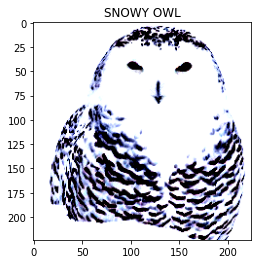

In [72]:
x, y = trainSet[40000]

className = list(trainSet.class_to_idx.keys())[list(trainSet.class_to_idx.values()).index(y)] # Get name of class
plt.title(className)
plt.imshow(x.permute(1, 2, 0))

In [73]:
trainLoader = DataLoader(trainSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, trainSet.__len__())))
validLoader = DataLoader(validSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, validSet.__len__())))
testLoader = DataLoader(testSet, batch_size=64)

In [74]:
def flatten(X):
  """
  Flatten an image to vector
  """
  N = X.shape[0] # Num in batch
  return X.view(N, -1)

class Flatten(nn.Module):
  def forward(self, X):
    return flatten(X)

In [75]:
def check_accuracy(model, dataLoader, typeOfCheck, device=torch.device('cpu')):
  """
  Checking accuracy on given dataSet in dataLoader
  typeOfCheck - train, validation or test
  """
  model = model.to(device=device)

  typeOfCheck = str.lower(typeOfCheck)

  model.eval()

  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for i, (x, y) in enumerate(dataLoader):
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      _, preds = scores.max(1)

      num_samples += preds.shape[0]
      num_correct += (preds == y).sum()

      if typeOfCheck == 'train' and i == 100: # Чтобы проверяться не на всём огромном train сете (16 * 64 = 1024 как и у validation)
        break

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f) in %s'% (num_correct, num_samples, 100 * acc, typeOfCheck))
    return acc

In [76]:
def train_model(model, optimizer, trainLoader, validationLoader, num_epoch=1, device=torch.device('cpu'), printAndSaveEvery=100, continueTraining=None, savePath = '/content/drive/MyDrive/'):
  """
  continueTraining is a dictionary including:
  1) train_accs - list of training accuracies
  2) val_accs - list of validation accuracies
  3) num_ep - number of epoch from which the model will continue training
  """
  import torch.nn.functional as F
  from os.path import join

  if continueTraining is None:
    print("Starting new training")
    best_acc = 0
    train_accuracies = []
    val_accuracies = []
    start_ep = 0
  else:
    train_accuracies = continueTraining['train_accs']
    val_accuracies = continueTraining['val_accs']
    start_ep = continueTraining['num_ep']
    best_acc = val_accuracies[-1]
    print("Continue training from " + str(start_ep) + " epoch")

  model = model.to(device=device)

  for e in range(start_ep, num_epoch):
    print("Start " + str(e) + " epoch")
    for t, (x, y) in enumerate(trainLoader):

      model.train()
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % printAndSaveEvery == 0 and t != 0:
        print("Iteration " + str(t) + ":")
        train_acc = check_accuracy(model, trainLoader, 'train', device)
        val_acc = check_accuracy(model, validationLoader, 'validation', device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if best_acc < val_acc:
          print("Goten new best val accuracy. Save new best model")
          best_acc = val_acc
          torch.save({
              'Model_state_dict': model.state_dict(),
              'Optimizer_state_dict': optimizer.state_dict(),
              'Num_epoch': e,
              'Train_accs': train_accuracies,
              'Val_accs': val_accuracies
          }, join(savePath, 'best_model.pt'))
          

    train_acc = check_accuracy(model, trainLoader, 'train', device)
    val_acc = check_accuracy(model, validationLoader, 'validation', device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    torch.save({
        'Model_state_dict': model.state_dict(),
        'Optimizer_state_dict': optimizer.state_dict(),
        'Num_epoch': e + 1,
        'Train_accs': train_accuracies,
        'Val_accs': val_accuracies
    }, join(savePath, 'best_model.pt'))

    if best_acc < val_acc:
          print("Goten new best val accuracy. Save new best model")
          best_acc = val_acc
          torch.save({
              'Model_state_dict': model.state_dict(),
              'Optimizer_state_dict': optimizer.state_dict(),
              'Num_epoch': e,
              'Train_accs': train_accuracies,
              'Val_accs': val_accuracies
          }, join(savePath, 'best_model.pt'))

  return(train_accuracies, val_accuracies)

In [77]:
def createModel():
  model = None
  optimizer = None

  input_channels = 3
  channel_1 = 64
  channel_2 = 128
  channel_3 = 256
  channel_4 = 512
  dense_1 = 1024
  dense_2 = 512
  num_classes = 325

  learning_rate = 1e-4
  weight_decay = 1e-5

  model = nn.Sequential(
      
      nn.Conv2d(in_channels=input_channels, out_channels=channel_1, kernel_size=5, stride=1, padding=2), # 224 x 224 x 128
      nn.BatchNorm2d(num_features=channel_1),
      nn.ReLU(),

      # nn.Conv2d(channel_1, channel_1, 5, 1, 2), # 224 x 224 x 64
      # nn.BatchNorm2d(num_features=channel_2),
      # nn.ReLU(),

      nn.MaxPool2d(kernel_size=2, stride=2), # 112 x 112 x 64

      nn.Conv2d(channel_1, channel_2, kernel_size=3, stride=1, padding=1), # 112 x 112 x 128
      nn.BatchNorm2d(num_features=channel_2),
      nn.ReLU(),

      # nn.Conv2d(channel_2, channel_2, kernel_size=3, stride=1, padding=1), # 112 x 112 x 128
      # nn.BatchNorm2d(num_features=channel_4),
      # nn.ReLU(),

      nn.MaxPool2d(kernel_size=2, stride=2), # 56 x 56 x 128

      nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1, padding=1), # 56 x 56 x 256
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      
      nn.MaxPool2d(kernel_size=2, stride=2), # 28 x 28 x 256

      nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 28 x 28 x 256
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      
      nn.MaxPool2d(kernel_size=2, stride=2), # 14 x 14 x 256
      
      nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 14 x 14 x 256
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      
      nn.MaxPool2d(kernel_size=2, stride=2), # 7 x 7 x 256

      Flatten(),
      nn.Linear(7 * 7 * 256, dense_1),
      nn.ReLU(),
      nn.Linear(dense_1, dense_2),
      nn.ReLU(),
      nn.Linear(dense_2, num_classes)
  )

  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  return (model, optimizer)

In [ ]:
model, optimizer = createModel()
train_acc, val_acc = train_model(model, optimizer, trainLoader, validLoader, 3, device, 100, savePath='/content/drive/MyDrive/BirdsModels')

Starting new training
Start 0 epoch
Iteration 100:
Got 148 / 6464 correct (2.29) in train
Got 40 / 1625 correct (2.46) in validation
Goten new best val accuracy. Save new best model
Iteration 200:
Got 521 / 6464 correct (8.06) in train
Got 135 / 1625 correct (8.31) in validation
Goten new best val accuracy. Save new best model
Iteration 300:
Got 826 / 6464 correct (12.78) in train
Got 225 / 1625 correct (13.85) in validation
Goten new best val accuracy. Save new best model
Iteration 400:
Got 1221 / 6464 correct (18.89) in train
Got 362 / 1625 correct (22.28) in validation
Goten new best val accuracy. Save new best model
Iteration 500:
Got 1864 / 6464 correct (28.84) in train
Got 486 / 1625 correct (29.91) in validation
Goten new best val accuracy. Save new best model
Iteration 600:
Got 2020 / 6464 correct (31.25) in train
Got 562 / 1625 correct (34.58) in validation
Goten new best val accuracy. Save new best model
Iteration 700:
Got 2204 / 6464 correct (34.10) in train
Got 608 / 1625 c

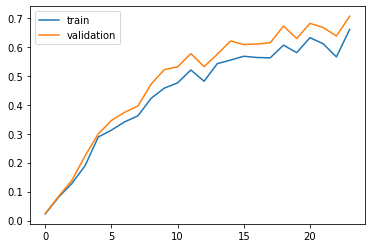

In [ ]:
plt.plot(range(len(train_acc)), train_acc, range(len(val_acc)), val_acc)
plt.legend(['train', 'validation'])

In [ ]:
model, optimizer = createModel()
model.cuda() # Adam requare change model to cuda before loading it from save

checkpoint = torch.load('/content/drive/MyDrive/BirdsModels/best_model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = train_model(model, optimizer, trainLoader, validLoader, 10, device, 100, 
                                 savePath='/content/drive/MyDrive/BirdsModels', continueTraining=contTrain)

Continue training from 3 epoch
Start 3 epoch
Iteration 100:
Got 4132 / 6464 correct (63.92) in train
Got 1129 / 1625 correct (69.48) in validation
Iteration 200:
Got 4403 / 6464 correct (68.12) in train
Got 1155 / 1625 correct (71.08) in validation
Goten new best val accuracy. Save new best model
Iteration 300:
Got 4264 / 6464 correct (65.97) in train
Got 1127 / 1625 correct (69.35) in validation
Iteration 400:
Got 4299 / 6464 correct (66.51) in train
Got 1169 / 1625 correct (71.94) in validation
Goten new best val accuracy. Save new best model
Iteration 500:
Got 4491 / 6464 correct (69.48) in train
Got 1180 / 1625 correct (72.62) in validation
Goten new best val accuracy. Save new best model
Iteration 600:
Got 4428 / 6464 correct (68.50) in train
Got 1186 / 1625 correct (72.98) in validation
Goten new best val accuracy. Save new best model
Iteration 700:
Got 4651 / 6464 correct (71.95) in train
Got 1195 / 1625 correct (73.54) in validation
Goten new best val accuracy. Save new best mo

In [106]:
# 3-th train with lover lr
model, optimizer = createModel()
model.cuda() # Adam requare change model to cuda before loading it from save

checkpoint = torch.load('/content/drive/MyDrive/BirdsModels/best_model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}

for g in optimizer.param_groups:
    g['lr'] = 1e-6

train_acc, val_acc = train_model(model, optimizer, trainLoader, validLoader, 15, device, 100, 
                                 savePath='/content/drive/MyDrive/BirdsModels', continueTraining=contTrain)

Continue training from 10 epoch
Start 10 epoch
Iteration 100:
Got 5790 / 6464 correct (89.57) in train
Got 1390 / 1625 correct (85.54) in validation
Goten new best val accuracy. Save new best model
Iteration 200:
Got 5832 / 6464 correct (90.22) in train
Got 1403 / 1625 correct (86.34) in validation
Goten new best val accuracy. Save new best model
Iteration 300:
Got 5852 / 6464 correct (90.53) in train
Got 1412 / 1625 correct (86.89) in validation
Goten new best val accuracy. Save new best model
Iteration 400:
Got 5898 / 6464 correct (91.24) in train
Got 1412 / 1625 correct (86.89) in validation
Iteration 500:
Got 5906 / 6464 correct (91.37) in train
Got 1419 / 1625 correct (87.32) in validation
Goten new best val accuracy. Save new best model
Iteration 600:
Got 5930 / 6464 correct (91.74) in train
Got 1428 / 1625 correct (87.88) in validation
Goten new best val accuracy. Save new best model
Iteration 700:
Got 5904 / 6464 correct (91.34) in train
Got 1421 / 1625 correct (87.45) in valid

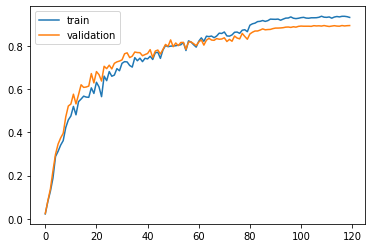

In [107]:
plt.plot(range(len(train_acc)), train_acc, range(len(val_acc)), val_acc)
plt.legend(['train', 'validation'])

In [105]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_summary(device='cuda'))
# torch.cuda.empty_cache()

566231040

In [ ]:
# def createModel():
#   model = None
#   optimizer = None

#   input_channels = 3
#   channel_1 = 64
#   channel_2 = 128
#   channel_3 = 256
#   channel_4 = 512
#   dense_1 = 1024
#   dense_2 = 512
#   num_classes = 325

#   learning_rate = 1e-4
#   weight_decay = 1e-5

#   model = nn.Sequential(
      
#       nn.Conv2d(in_channels=input_channels, out_channels=channel_1, kernel_size=5, stride=1, padding=2), # 224 x 224 x 64
#       nn.BatchNorm2d(num_features=channel_1),
#       nn.ReLU(),

#       nn.Conv2d(channel_1, channel_1, 5, 1, 2), # 224 x 224 x 64
#       nn.BatchNorm2d(num_features=channel_1),
#       nn.ReLU(),

#       nn.MaxPool2d(kernel_size=2, stride=2), # 112 x 112 x 64

#       nn.Conv2d(channel_1, channel_2, kernel_size=3, stride=1, padding=1), # 112 x 112 x 128
#       nn.BatchNorm2d(num_features=channel_2),
#       nn.ReLU(),

#       nn.Conv2d(channel_2, channel_2, kernel_size=3, stride=1, padding=1), # 112 x 112 x 128
#       nn.BatchNorm2d(num_features=channel_2),
#       nn.ReLU(),

#       nn.MaxPool2d(kernel_size=2, stride=2), # 56 x 56 x 128

#       nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1, padding=1), # 56 x 56 x 256
#       nn.BatchNorm2d(num_features=channel_3),
#       nn.ReLU(),

#       nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 56 x 56 x 256
#       nn.BatchNorm2d(num_features=channel_3),
#       nn.ReLU(),
      
#       nn.MaxPool2d(kernel_size=2, stride=2), # 28 x 28 x 256

#       nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 28 x 28 x 256
#       nn.BatchNorm2d(num_features=channel_3),
#       nn.ReLU(),

#       # nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 28 x 28 x 256
#       # nn.BatchNorm2d(num_features=channel_3),
#       # nn.ReLU(),
      
#       nn.MaxPool2d(kernel_size=2, stride=2), # 14 x 14 x 256
      
#       nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 14 x 14 x 256
#       nn.BatchNorm2d(num_features=channel_3),
#       nn.ReLU(),

#       # nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 14 x 14 x 256
#       # nn.BatchNorm2d(num_features=channel_3),
#       # nn.ReLU(),
      
#       nn.MaxPool2d(kernel_size=2, stride=2), # 7 x 7 x 256

#       Flatten(),
#       nn.Linear(7 * 7 * channel_3, dense_1),
#       nn.ReLU(),
#       nn.Dropout(),
#       nn.Linear(dense_1, dense_2),
#       nn.ReLU(),
#       nn.Dropout(),
#       nn.Linear(dense_2, num_classes)
#   )

#   optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#   return (model, optimizer)

In [ ]:
# model, optimizer = createModel()
# train_acc, val_acc = train_model(model, optimizer, trainLoader, validLoader, 3, device, 100, savePath='/content/drive/MyDrive/BirdsModels')